In [1]:
###############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def capital_data_importer(datafolder,start_year,num_years):
    '''
    INPUTS:
        datafolder: the filepath for the data, as a string
        start_year: the initial year desired, in the format YYYY
        num_years: the number of years desired, as a non-negative integer
        
    RETURN:
        all_data: a pandas dataframe containing all the data
    '''
    # We initialise an empty dictionary.
    all_data = {}
    # Then we loop through the years...
    for n in range(num_years):
        # ...and through the quarters of each year.
        for m in range(4):
            # We assign a dictionary key of the form, e.g., 'Y2013Q2'.
            # Then we give it its value: a pandas dataframe from the imported
            #  csv data.
            all_data['Y{0}'.format(str(int(n+start_year))+'Q'+str(int(m+1)))]=\
            pd.read_csv(datafolder+str(int(n+start_year))+r'Q'+str(int(m+1))+\
                        '-capitalbikeshare-tripdata.csv')
    # Then we concatenate all the dataframes.
    all_data = pd.concat(all_data.values(),axis=0).reset_index(drop=True)
    return all_data

In [3]:
datafolder = "C:/Users/sneak/Documents/Python Scripts/Bike_sharing/"
start_year = 2013
num_years = 5
all_data = capital_data_importer(datafolder,start_year,num_years)

In [4]:
def stations_name_num_splitter (all_data, datafolder=None):
    '''
    INPUTS:
        all_data  : a pandas dataframe containing the Capital bikesharing data
        datafolder: (optional) a path to a folder, as a string
    RETURN:
        a dictionary:
            'Station numbers': a pandas dataframe with columns 'Start date',
                               'End date', 'Start stn', 'End stn'. Entries of
                               'Start/End date' are strings, entries of
                               'Start/End stn' are integers.
            'Station names'  : a pandas dataframe with columns 'Start date',
                               'End date', 'Start station', 'End station'.
                               Entries of 'Start/End date' are strings, entries
                               of 'Start/End station' are strings (names)

    The function can also save station_names to csv in datafolder, so
    station_names can be deleted from the RAM if desired.
    
    WARNING: calling this function with datafolder != None will overwrite
    station_names.csv in datafolder!
    '''


    
    if datafolder != None:
        station_names =\
        all_data[['Start date','End date','Start station','End station']]
        station_names.to_csv(datafolder+'station_names.csv',index=False)
        del station_names

    station_nums =\
    all_data.drop(["Duration","Start station","End station",\
                   "Bike number","Member type"],axis=1)
    station_nums.rename(columns={'Start station number':'Start stn',\
                                 'End station number':'End stn'},inplace=True)
    station_nums['Start stn'] = station_nums['Start stn'].apply(int)
    station_nums['End stn'] = station_nums['End stn'].apply(int)
    # Now we find the minimum value:
    stn_min = np.min(station_nums["Start stn"])
    # Then we subtract it from all the station labels:
    station_nums["Start stn"] = station_nums["Start stn"] - stn_min
    station_nums["End stn"] = station_nums["End stn"] - stn_min
    
    if datafolder == None:
        output = {'Station numbers' : station_nums,\
                  'Station names' : station_names}
    else:
        output = {'Station numbers' : station_nums}

    return output

In [5]:
split_data_dict = stations_name_num_splitter(all_data,datafolder=datafolder)

In [6]:
split_data_dict["Station numbers"].head()

,Start date,End date,Start stn,End stn
0,2013-01-01 00:03:55,2013-01-01 00:15:24,101,106
1,2013-01-01 00:04:39,2013-01-01 00:16:19,236,304
2,2013-01-01 00:10:01,2013-01-01 00:16:06,257,239
3,2013-01-01 00:12:55,2013-01-01 00:17:47,614,612
4,2013-01-01 00:13:24,2013-01-01 00:17:07,239,214


In [7]:
def station_binner(station_nums,time_interval='H'):
    '''
    INPUTS:
        station_nums : a dataframe with columns for dates and station numbers
                       for the start and end of bike journeys; ideally 'Station
                       numbers' from the output of stations_name_num_splitter
        time_interval: (optional) a string specifying the time-intervals for
                       making the bins; default value 'H' (1 hour)
    RETURN:
        a dictionary with 3 entries that are all dataframes:
            'Starts by bin': the total journeys started from each station,
                             arranged in columns by station number and in rows
                             by the binning time_interval
            'Ends by bin'  : the total journeys ended at each station, arranged
                             in columns by station number and in rows by the
                             binning time_interval
            'Demand by bin': an approximation of the demand for bikes at each
                             station, arranged in columns by station number and
                             in rows by the binning time_interval
    
    N.B. The demand in each time_interval is calculated as follows: take the
    total journeys started at each station in that time-interval, and subtract
    the total journeys ended at the corresponding station in the previous
    time-interval.
    '''
    
    start_stns = pd.DataFrame(station_nums['Start stn'])
    start_stns.index=pd.DatetimeIndex(station_nums['Start date'])
    del start_stns.index.name
    
    end_stns = pd.DataFrame(station_nums['End stn'])
    end_stns.index=pd.DatetimeIndex(station_nums['End date'])
    del end_stns.index.name
    
    def resampled_vals_cntr(x):
        y = pd.Series(x)
        return y.value_counts().fillna(0)
    
    start_stns = start_stns.resample(time_interval)
    list_starts = start_stns['Start stn'].apply(list)
    starts_by_bin = list_starts.apply(lambda x: resampled_vals_cntr(x)).\
                                fillna(0).astype(int)

    end_stns = end_stns.resample(time_interval)
    list_ends = end_stns['End stn'].apply(list)
    ends_by_bin = list_ends.apply(lambda x: resampled_vals_cntr(x)).fillna(0).\
                            astype(int)
    ends_shifted = pd.concat([ends_by_bin.iloc[-1:],ends_by_bin.iloc[:-1]])
    ends_shifted.index = ends_by_bin.index
    
    demand_by_bin = (starts_by_bin - ends_shifted).fillna(0).astype(int)
    
    return {'Starts by bin': starts_by_bin, 'Ends by bin' : ends_by_bin,\
            'Demand by bin' : demand_by_bin}

In [8]:
binned_stations_dict = station_binner(split_data_dict['Station numbers'])

In [9]:
starts_by_hr = binned_stations_dict['Starts by bin']
ends_by_hr = binned_stations_dict['Ends by bin']
demand_by_hr = binned_stations_dict['Demand by bin']

In [11]:
def dataframe_fft(binned_data,figsize=None,title=None):
    F_data = np.fft.fft(np.array(binned_data),axis=0)
    T = (binned_data.index[1]-binned_data.index[0]).total_seconds()
    ttl = title
    
    if isinstance(figsize, tuple):
        fourier_plot(F_data,T,figsize=figsize,title=ttl)
    
    return F_data, T

In [12]:
def fourier_plot(fourier_array,time_interval,figsize=(16,8),title=None):
    N = np.size(fourier_array,axis=0)
    F_X = np.linspace(0,1/(2*time_interval),N//(2))
    plt.figure(figsize=figsize)
    if isinstance(title, str):
        plt.title(title)
    arr_for_plot = fourier_array[:N//(2)] if fourier_array.ndim == 1 else fourier_array[:N//(2)]
    plt.plot(F_X,np.abs(arr_for_plot/np.sqrt(N)))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Normalised discrete Fourier transform (original units)')
    plt.grid()
    plt.show()

In [13]:
F_data, T = dataframe_fft(demand_by_hr)

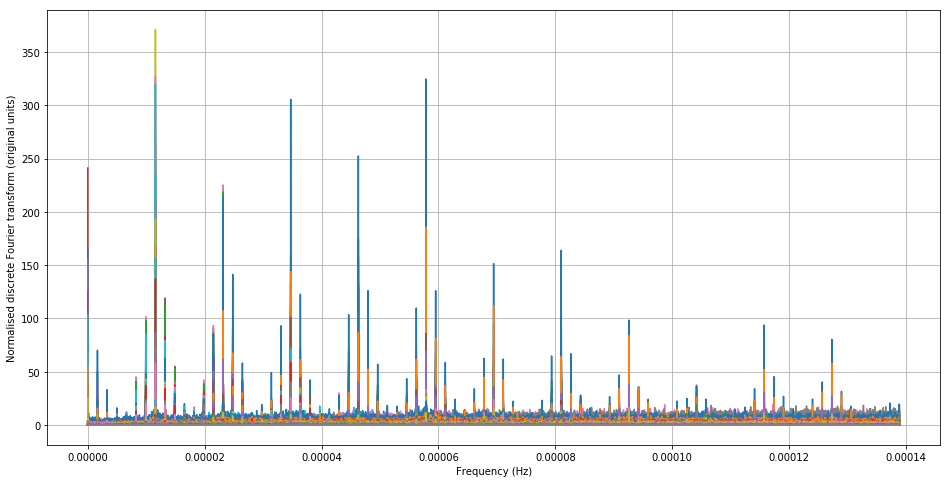

In [14]:
fourier_plot(F_data,T)

In [15]:
# We'll use scipy's signal processing function, find_peaks, which finds the
# positions of local maxima in 1-dim numpy arrays.
from scipy.signal import find_peaks

# However find_peaks doesn't see peaks at end-points, so we make a small
# adjustment to it.
def find_peaks_ends (x, height):
    '''
    INPUTS:
        x and height from find_peaks
        (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find
        _peaks.html)
    RETURN:
        same as find_peaks (positions of local maxima in x), except also finds
        the end-points if they are local maxima
    '''
    
    shift = 0
    if (x[0] >= x[1]) & (x[-1] >= x[-2]):
        y = np.append(np.insert(x, 0, x[0]-1), x[-1]-1)
        shift = 1
    elif x[0] >= x[1]:
        y = np.insert(x, 0, x[0]-1)
        shift = 1
    elif x[-1] >= x[-2]:
        y = np.append(x, x[-1]-1)
    else:
        y = x
        
    return find_peaks(y, height)[0] - shift
    # We take the 0th component of the output to remove the "height"
    # information automatically supplied by find_peaks.

In [16]:
# Our second function takes find_peaks_ends and applies it to a specified axis
# of a 2-dimensional numpy array.
def max_ovr_thresh2 (array, T_interv, ax=0, x_thresh=0, y_thresh=0):
    '''
    INPUTS:
        array   : a (non-empty) 2-dimensional numpy array
        
        T_interv: distance between two consecutive x-points
        
        ax      : the axis on which to find the maxima, i.e., 0 (maxima along
                  each column) or 1 (maxima along each row)
        x_thresh: a non-negative number, or a 1-dimensional numpy array of non-
                  -negative numbers (length must equal the non-ax dimension of
                  array!)
        y_thresh: a non-negative number, or a 1-dimensional numpy array of non-
                  -negative numbers (length must equal the non-ax dimension of
                  array!)
    
    RETURN:
        a dictionary of length the OTHER axis of array, i.e., 1 or 0 correspon-
        -dingly, whose entries are 1-dim numpy arrays of the local maxima along
        columns (ax=0) or rows (ax=1) that also exceed thresh
    '''
 
    if ax == 1:
        array = np.transpose(array)
    N = np.size(array,axis=0)
    F_X_full = np.linspace(0,1/(T_interv),N)
    
    sz = np.size(array,axis=1)
    if not np.shape(y_thresh): # checks if y_thresh is a scalar
        y_thresh = [y_thresh for j in range(sz)] # then fills an array with the
                                                 # scalar value
    elif len(y_thresh) != sz: # otherwise checks if the vector y_thresh has an
                              # appropriate size
        raise ValueError("size of y_threshold ({0}) does not match size of "+\
        "desired axis of array ({1})".format(y_thresh.size,sz))
    
    if not np.shape(x_thresh): # checks if x_thresh is a scalar
        x_thresh = [x_thresh for j in range(sz)] # then fills an array with the
                                                 # scalar value
    elif len(x_thresh) != sz: # otherwise checks if the vector x_thresh has an
                              # appropriate size
        raise ValueError("size of x_threshold ({0}) does not match size of "+\
        "desired axis of array ({1})".format(x_thresh.size,sz))

    # We initialise our dictionary for the indices.
    indices = {j : [] for j in range(sz)}
    for j in range(np.size(array,axis=1)):
    # Then for each column (row if ax==1) we find all the peaks above y_thresh.
        indices[j] = find_peaks_ends(x = array[:,j], height = y_thresh[j])
    # Then we choose those for which the x-value is less than x_thresh; since
    # we're working with Fourier transform data this is symmetric so we also
    # choose the x-values greater than the right-hand end minus x_thresh.
        indices[j] = [idx for idx in indices[j] if\
                      F_X_full[idx] < x_thresh or\
                      F_X_full[idx] > F_X_full[-1] - x_thresh]
        
    return indices

In [17]:
###############################################################################
def Fourier_series_from_index(f_array, indices):
    F_dom_freqs = np.zeros(np.size(f_array))
    for j in indices:
        F_dom_freqs[indices[j],j] = f_array[indices[j],j]
    reconstr = np.fft.ifft(F_dom_freqs,axis=0)
    return reconstr

In [18]:
def plot_mult_time_series\
(series_dict,start_date=None,end_date=None,figsize=(16,8)):
    if start_date == None:
        start_dts = pd.Series([series_dict[key].index[0]\
                               for key in series_dict])
        start_date = start_dts.max()
    if end_date == None:
        end_dts = pd.Series([series_dict[key].index[-1]\
                             for key in series_dict])
        end_date = end_dts.min()
        
    fig, ax = plt.subplots(figsize=figsize)
    for key in series_dict:
        ax.plot(series_dict[key].loc[start_date:end_date],label=key)
    
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

In [19]:
some_demands = {'Demand by hour at station 7':demand_by_hr[7],'Demand by hour at station 15':demand_by_hr[15].iloc[24:]}

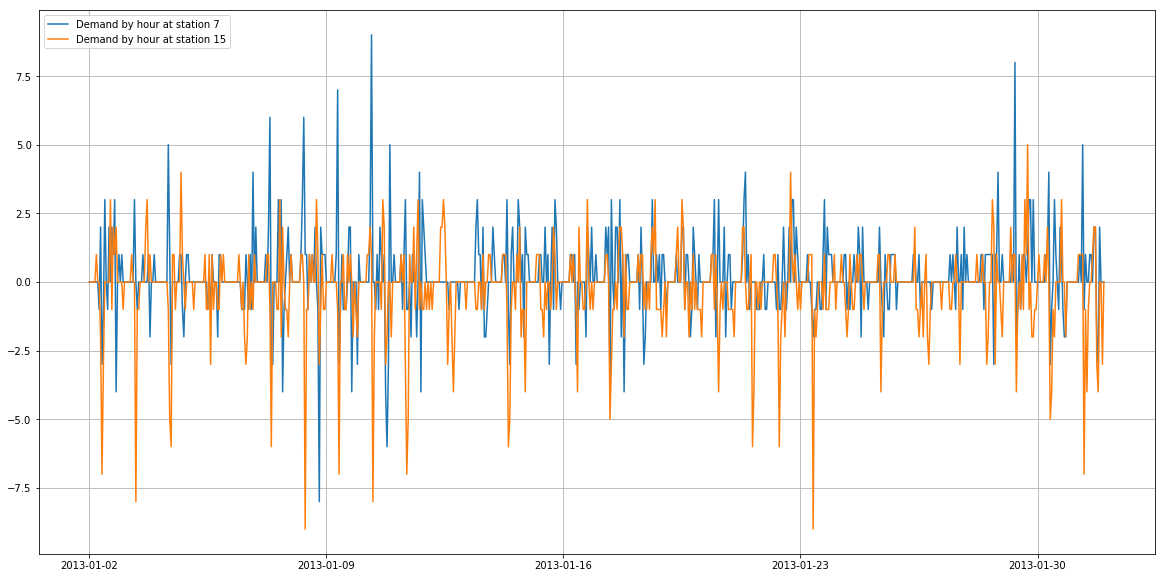

In [20]:
plot_mult_time_series(some_demands,end_date='2013-01-31 23:00:00',figsize=(20,10))

In [21]:
def weekday_splitter(df,reset_index=False):
    if not isinstance(df.index,pd.DatetimeIndex):
        raise ValueError('Index must be of type pd.DatetimeIndex')
    else:
        df = df.copy() # to avoid over-writing errors
        df['Day of the week'] = df.index.weekday
        df['Workday'] = df['Day of the week']\
                            .apply(lambda x: 1 if x<5 else 0)
        df['Hour and date'] = df.index
        df_workdays = df[df.Workday == 1]
        df_weekends = df[df.Workday == 0]
        df_workdays = df_workdays.drop(['Day of the week','Workday'],axis=1)
        df_weekends = df_weekends.drop(['Day of the week','Workday'],axis=1)
###############################################################################
        if reset_index:
            time_interval = df.index[1]-df.index[0]
            df_workdays.index\
            = pd.timedelta_range(start='0 days 0 hours',\
                                 periods=len(df_workdays),\
                                 freq = time_interval)
            df_weekends.index\
            = pd.timedelta_range(start='0 days 0 hours',\
                                 periods=len(df_weekends),
                                 freq = time_interval)
    return {'Workdays' : df_workdays, 'Weekends' : df_weekends}

In [23]:
tempor = demand_by_hr.copy()

In [24]:
split = weekday_splitter(tempor,reset_index=True)

In [25]:
workdays, weekends = split['Workdays'], split['Weekends']

In [26]:
wrk_fourier, _ = dataframe_fft(workdays.drop(["Hour and date"],axis=1))

In [27]:
we_fourier, _ = dataframe_fft(weekends.drop(["Hour and date"],axis=1))

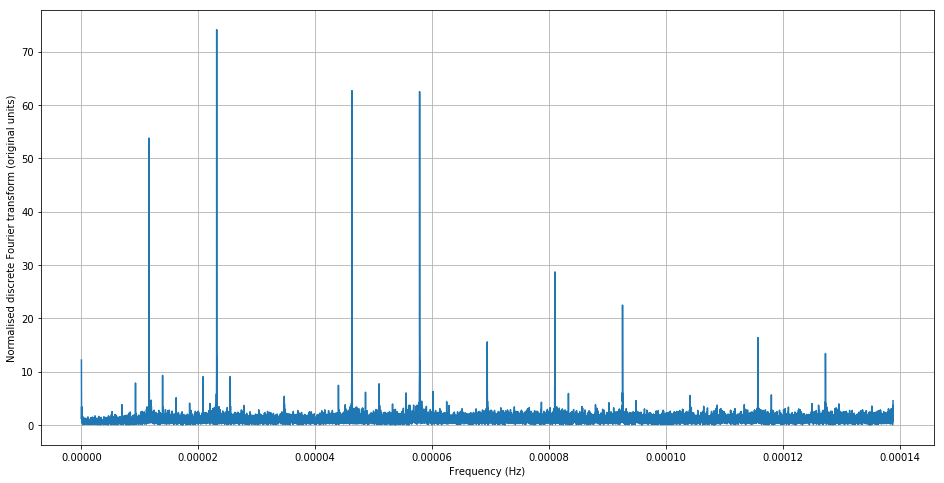

In [28]:
fourier_plot(wrk_fourier[:,9],T)

In [ ]:
wrk_fourier.ndim

In [ ]:
n = 25
pd.timedelta_range(start='0 days 00:00:00',end=t*(n+1),periods=n)

In [ ]:
t = demand_by_hr.index[1]-demand_by_hr.index[0]

In [ ]:
t*2

In [ ]:
t*1000